# Resizer in Programmable Logic (PL) - Application Notebook

##### This reference design illustrates how to run a resizer IP on the **Programmable Logic (PL)** using Jupyter Notebooks and Python

 > The resize IP transforms the source image to the size of the destination image. Different types of interpolation techniques can be used in resize function,
namely: Nearest-neighbor, Bilinear, and Area interpolation. The type of interpolation can be passed as a parameter to the Python API.    
> https://www.xilinx.com/support/documentation/sw_manuals/xilinx2017_1/ug1233-xilinx-opencv-user-guide.pdf

<!--<img src="./images/resizenb.png" width="800" height="650"/>-->
   
## Contents    
  

* [Image Resizing in Programmable Logic](#Image-Resizing-in-Programmable-Logic)
* [Import libraries](#Import-libraries)
* [Download the Resize IP bitstream](#Download-the-Resize-IP-bitstream)
* [Create an Image object using PIL in SW](#Create-an-Image-object-using-PIL-in-SW)
* [Display the image to be resized](#Display-the-image-to-be-resized)
* [Resizing](#Resizing)
* [References](#References)   

## Image Resizing in Programmable Logic


<img src="./images/resize_bd.png" width="800" height="650"/>

## Import libraries

In [1]:
from PIL import Image
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay

## Download the Resize IP bitstream

In [2]:
resize_design = Overlay(
    "/usr/local/lib/python3.6/dist-packages/helloworld/bitstream/resizer.bit")

Then create DMA and Resizer IP objects.

In [3]:
dma = resize_design.axi_dma_0
resizer = resize_design.resize_accel_0


<img src="./images/resize_bit.png" width="600" height="450"/>


## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

In [4]:
image_path = "images/paris.jpg"
original_image = Image.open(image_path)
original_image.load()

We now create a numpy array of the pixels.

In [5]:
input_array = np.array(original_image)

<img src="images/sd2dram.png" width="650" height="550"/>

## Display the image to be resized

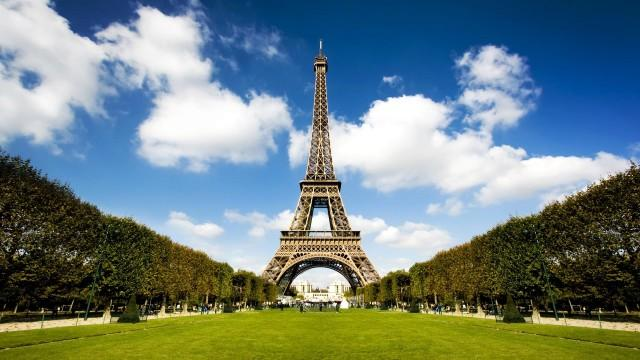

In [6]:
input_image = Image.fromarray(input_array)
display(input_image)

Let's double-check the original image size.

In [7]:
old_width, old_height = original_image.size
print("Image size: {}x{} pixels.".format(old_width, old_height))

Image size: 640x360 pixels.


## Resizing
 
We can set resize dimensions.
1. Downscale factor range:  1 to 7 (by design of the resize IP)
2. Max input and output size of Image is 640x360 for this version of resize IP

In [8]:
resize_factor = 2
new_width = int(old_width/resize_factor)
new_height = int(old_height/resize_factor)

We now allocate memory to process data on PL.
Data is provided as contiguous memory blocks.
The size of the buffer depends on the size of the input or output data.
The image dimensions extracted from the read image are used to allocate contiguous memory blocks.   
We will call `cma_array()` to perform the allocation.

In [9]:
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(old_height, old_width, 3), 
                           dtype=np.uint8, cacheable=1)
out_buffer = xlnk.cma_array(shape=(new_height, new_width, 3), 
                            dtype=np.uint8, cacheable=1)

Documentation snippet for `xlnk.cma_array`:

```python
"""
Get a contiguously allocated numpy array

Parameters
----------
shape : int or tuple of int
    The dimensions of the array to construct - We use (height, width, depth)
dtype : numpy.dtype or str
    The data type to construct - We use 8-bit unsigned int

"""
```


<img src="./images/local2shared.png" width="650" height="550"/>


We now display the image in buffer.

__Note : The `input_array` has to be copied into the contiguous memory array (deep copy).__

The input buffer size should be 640 x 360 x 3 (height x width x depth).

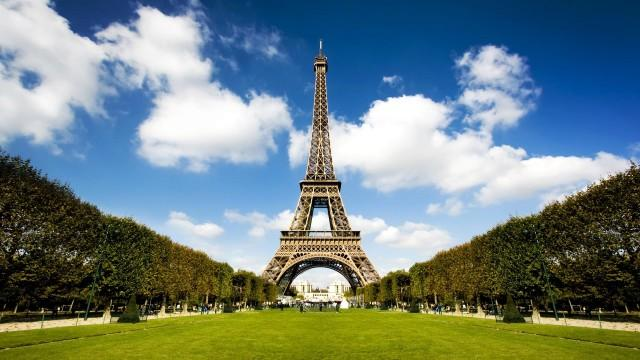

Image size: 640x360 pixels.


In [10]:
in_buffer[0:640*360*3] = input_array
buf_image = Image.fromarray(in_buffer)
display(buf_image)
print("Image size: {}x{} pixels.".format(old_width, old_height))

We can now run the resizer IP.
We will push the data from input buffer through the pipeline to the output buffer.


<img src="./images/resize_accel.png" width="650" height="550"/>


We will first need to setup resizer and DMA IPs using MMIO interface 
before we stream image data to them.
For example, we need to write dimensions data to MMIO registers of resizer.

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x10            | number of rows for original picture    |
| 0x18            | number of columns for original picture |
| 0x20            | number of rows for resized picture     |
| 0x28            | number of columns for resized picture  |

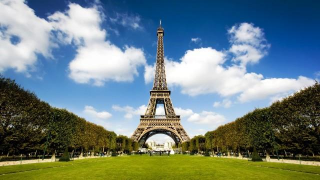

Resized in Hardware(PL): 320x180 pixels.


In [11]:
resizer.write(0x10, old_height)
resizer.write(0x18, old_width)
resizer.write(0x20, new_height)
resizer.write(0x28, new_width)

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

result = Image.fromarray(out_buffer)
display(result)
print("Resized in Hardware(PL): {}x{} pixels.".format(new_width, new_height))

We can time the resize in PL operation.

| register offset | configuration                          |
|-----------------|----------------------------------------|
| 0x10            | number of rows for original picture    |
| 0x18            | number of columns for original picture |
| 0x20            | number of rows for resized picture     |
| 0x28            | number of columns for resized picture  |

In [12]:
%%timeit

resizer.write(0x10, old_height)
resizer.write(0x18, old_width)
resizer.write(0x20, new_height)
resizer.write(0x28, new_width)

def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    resizer.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

run_kernel()

result = Image.fromarray(out_buffer)

100 loops, best of 3: 7.6 ms per loop


Finally we need to reset all the contiguous memory buffers.

In [13]:
xlnk.xlnk_reset()

[Contents](#Contents)

# References

https://pillow.readthedocs.io/en/3.1.x/index.html   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/python_environment.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks.ipynb   
https://github.com/Xilinx/PYNQ/blob/master/docs/source/jupyter_notebooks_advanced_features.ipynb   